# VAE

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from dataload import AirFoilDatasetParsec 

class Encoder(nn.Module):
    def __init__(self, airfoil_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(airfoil_dim, 2056)
        self.fc2 = nn.Linear(2056, 128)
        self.fc3_mu = nn.Linear(128, latent_dim)
        self.fc3_logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        mu = self.fc3_mu(x)
        logvar = self.fc3_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, airfoil_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 2056)
        self.fc2 = nn.Linear(2056, 128)
        self.fc3 = nn.Linear(128, airfoil_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

class VAE(nn.Module):
    def __init__(self, airfoil_dim, latent_dim):
        super(VAE, self).__init__()
        self.enc = Encoder(airfoil_dim, latent_dim)
        self.dec = Decoder(latent_dim, airfoil_dim)

    def forward(self, x):
        mu, logvar = self.enc(x)
        z = self.reparameterize(mu, logvar)
        return self.dec(z), mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.dec(z)

def plot_airfoils(airfoil_x, airfoil_y, title="Airfoil Plot"):
    idx = 0
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    for row in ax:
        for col in row:
            if idx >= len(airfoil_y):
                col.axis('off')
            else:
                y_plot = airfoil_y[idx].numpy() if isinstance(airfoil_y[idx], torch.Tensor) else airfoil_y[idx]
                col.scatter(airfoil_x, y_plot, s=0.6, c='black')
                col.axis('off')
                col.axis('equal')
                idx += 1
    plt.show()


In [3]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize dataset and dataloader
dataset = AirfoilDataset(path='clean_data_200/')
airfoil_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
airfoil_x = dataset.get_x()  # Used for plotting later
airfoil_dim = airfoil_x.shape[0]
latent_dim = 32
vae = VAE(airfoil_dim, latent_dim).to(device)

# Define loss function and optimizer
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD

optim = Adam(vae.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optim, 'min', factor=0.75, patience=20, verbose=True)
num_epochs = 250

# beta scheduling
beta_start = 0.0
beta_end = 0.01
beta_increment = (beta_end - beta_start) / num_epochs

# Train the model
total_losses, mse_losses, kld_losses = [], [], []
for epoch in range(num_epochs):
    epoch_losses, epoch_mse_losses, epoch_kld_losses = [], [], []
    current_beta = beta_start + beta_increment * epoch
    for local_batch in airfoil_dataloader:
        y_real = local_batch.to(device)
        recon_y, mu, logvar = vae(y_real)
        loss = loss_function(recon_y, y_real, mu, logvar, beta=current_beta)
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_losses.append(loss.item())
    scheduler.step(sum(epoch_losses) / len(epoch_losses))
    total_losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f'Epoch {epoch+1}: Total Loss: {total_losses[-1]:.4f}, learning rate: {optim.param_groups[0]["lr"]:.6f}')


Using device: cuda


/home/reid/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1: Total Loss: 16.1582, learning rate: 0.001000
Epoch 2: Total Loss: 3.4363, learning rate: 0.001000
Epoch 3: Total Loss: 2.0455, learning rate: 0.001000
Epoch 4: Total Loss: 1.8443, learning rate: 0.001000
Epoch 5: Total Loss: 1.6676, learning rate: 0.001000
Epoch 6: Total Loss: 2.1183, learning rate: 0.001000
Epoch 7: Total Loss: 1.4540, learning rate: 0.001000
Epoch 8: Total Loss: 1.7181, learning rate: 0.001000
Epoch 9: Total Loss: 1.7441, learning rate: 0.001000
Epoch 10: Total Loss: 1.5871, learning rate: 0.001000
Epoch 11: Total Loss: 1.6777, learning rate: 0.001000
Epoch 12: Total Loss: 1.6735, learning rate: 0.001000
Epoch 13: Total Loss: 1.4245, learning rate: 0.001000
Epoch 14: Total Loss: 1.5802, learning rate: 0.001000
Epoch 15: Total Loss: 1.7345, learning rate: 0.001000
Epoch 16: Total Loss: 1.5887, learning rate: 0.001000
Epoch 17: Total Loss: 1.2267, learning rate: 0.001000
Epoch 18: Total Loss: 1.1241, learning rate: 0.001000
Epoch 19: Total Loss: 1.2674, learni

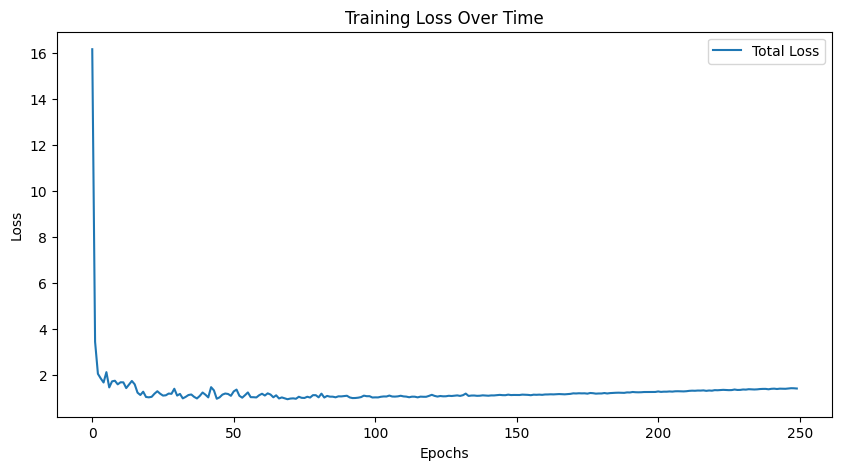

noise shape: torch.Size([128, 32])


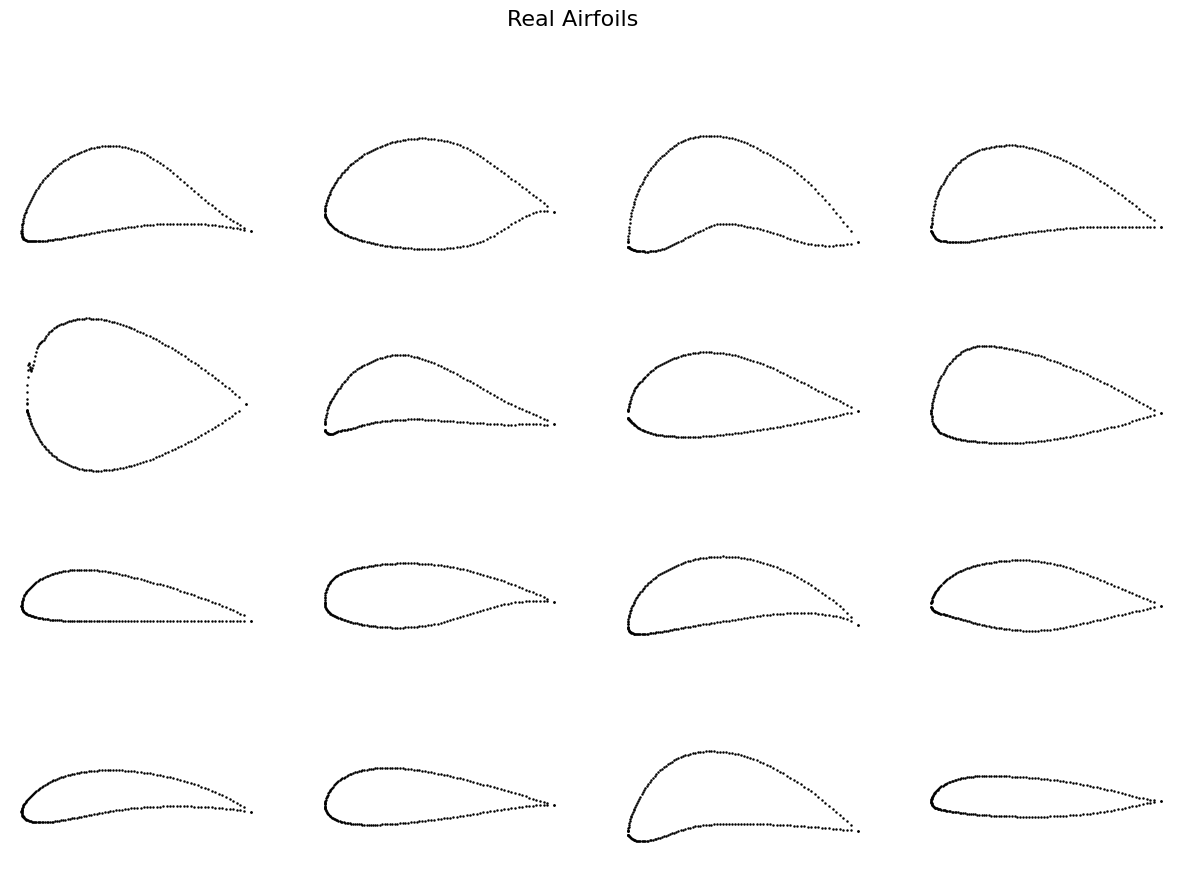

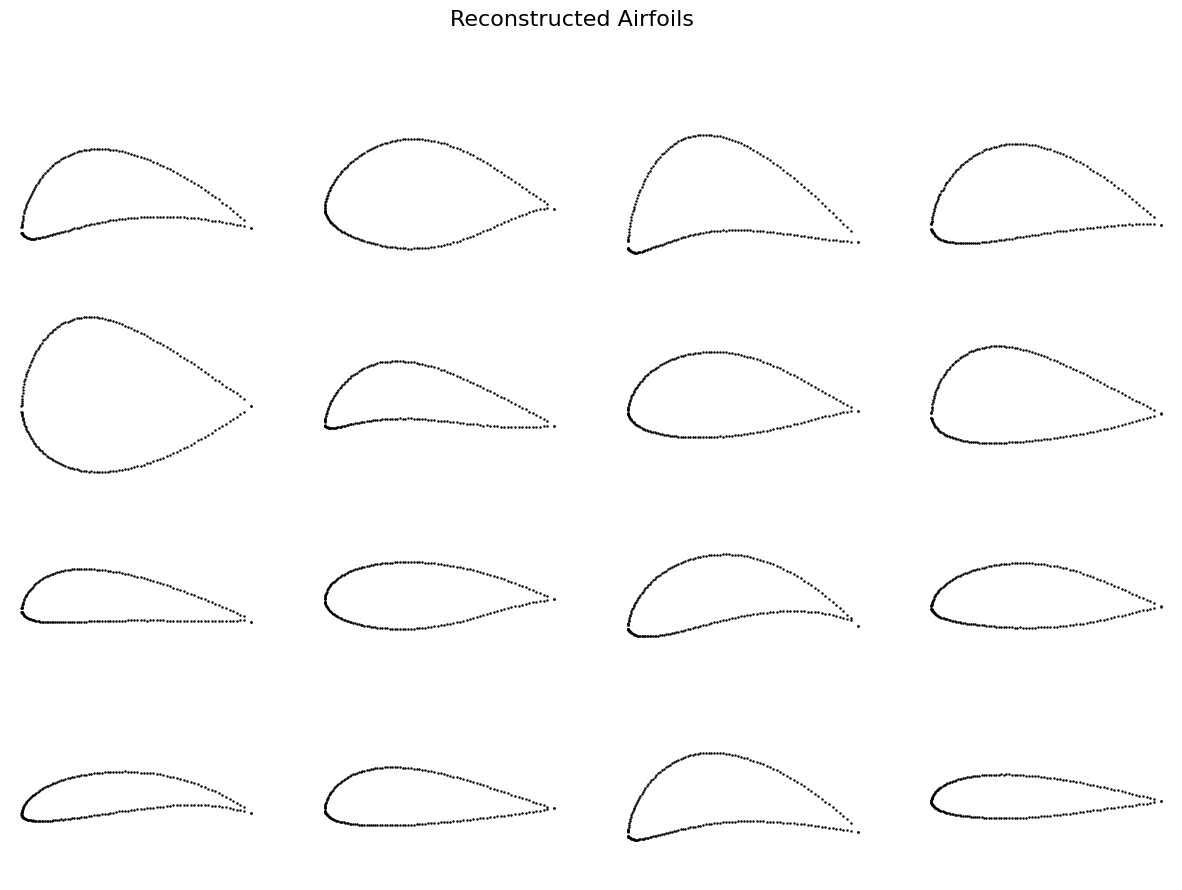

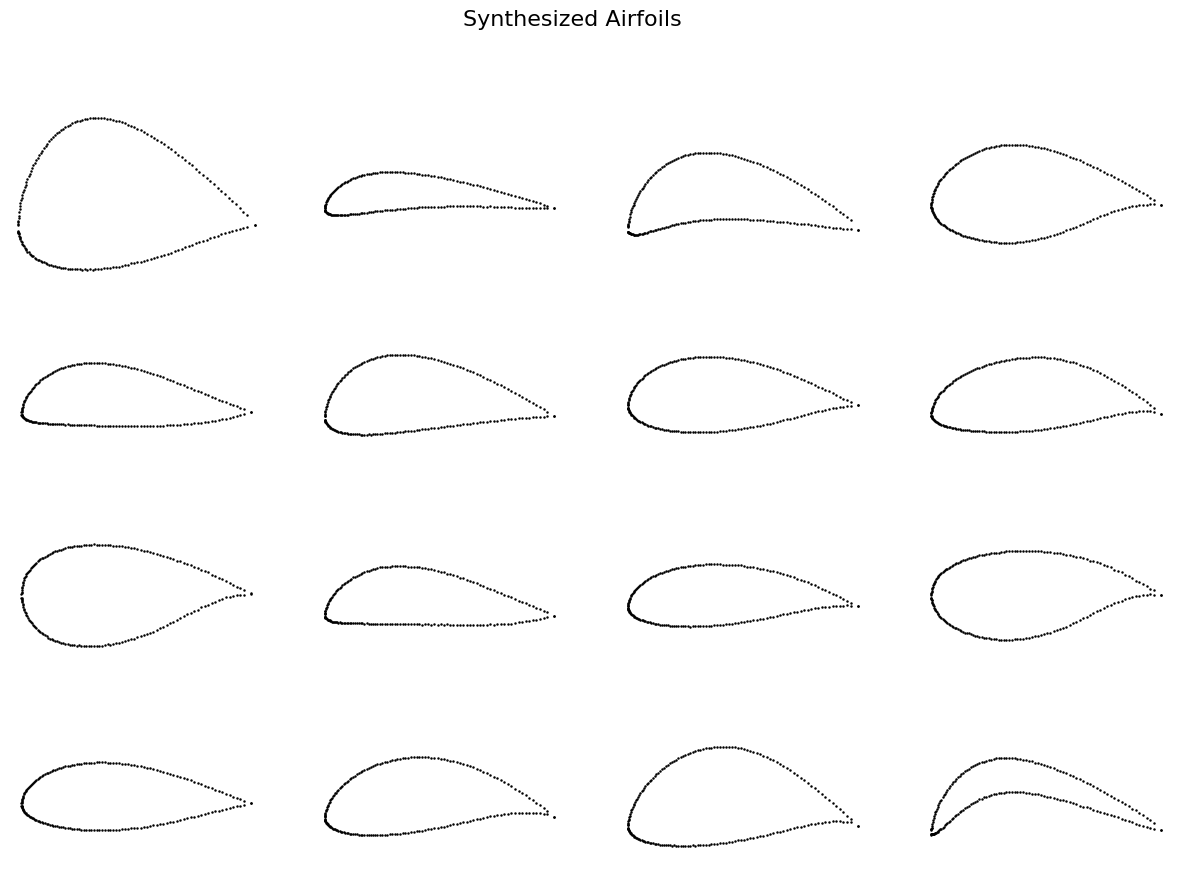

In [4]:
# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(total_losses, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# Generate and plot airfoils from the model
num_samples = 128
real_airfoils = dataset.get_y()[:num_samples]
if all(y.shape == real_airfoils[0].shape for y in real_airfoils):
    real_airfoils_tensor = torch.stack(real_airfoils).to(device)
else:
    max_length = max(y.size(0) for y in real_airfoils)
    real_airfoils_tensor = torch.stack([nn.functional.pad(y, (0, max_length - y.size(0))) for y in real_airfoils]).to(device)
recon_airfoils, _, _ = vae(real_airfoils_tensor)
recon_airfoils = recon_airfoils.detach().cpu().numpy()
noise = torch.randn(num_samples, latent_dim).to(device)
print("noise shape:", noise.shape)
gen_airfoils = vae.decode(noise).detach().cpu().numpy()
plot_airfoils(airfoil_x, real_airfoils, title="Real Airfoils")
plot_airfoils(airfoil_x, recon_airfoils, title="Reconstructed Airfoils")
plot_airfoils(airfoil_x, gen_airfoils, title="Synthesized Airfoils")


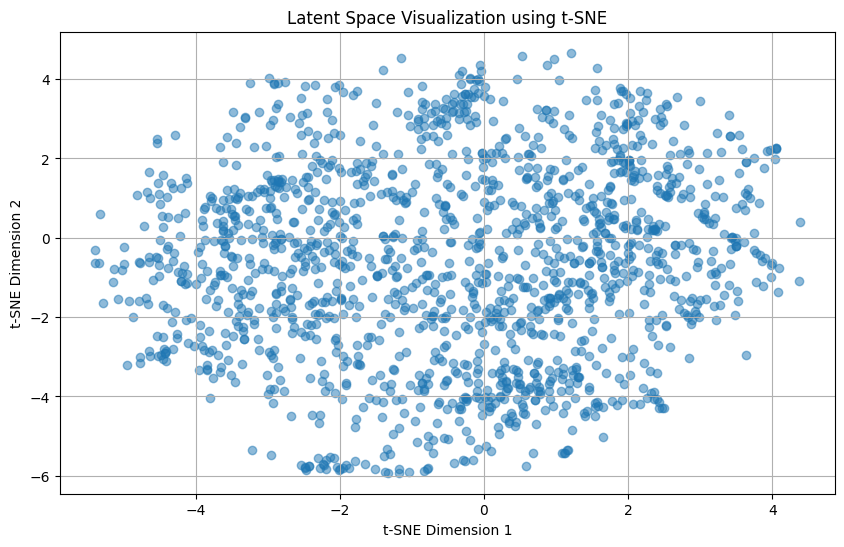

In [6]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_latent_space(vae, data_loader, device):
    # Encode all data to get the latent vectors
    mu_list = []
    for data in data_loader:
        data = data.to(device)
        with torch.no_grad():
            mu, _ = vae.enc(data)
            mu_list.append(mu)

    # Concatenate all mu vectors from batches and remove any extra dimensions
    mu_tensor = torch.cat(mu_list, dim=0)
    mu_tensor = mu_tensor.view(mu_tensor.size(0), -1)  # Ensure it's a 2D array
    # Apply t-SNE to reduce dimensions to 2
    tsne = TSNE(n_components=2, random_state=42, n_iter=5000, perplexity=500)
    mu_tsne = tsne.fit_transform(mu_tensor.cpu().numpy())  # Ensure tensor is on CPU

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(mu_tsne[:, 0], mu_tsne[:, 1], alpha=0.5)
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.show()

# Call the visualization function
# Assume 'device' is defined, 'vae' is your trained model, and 'airfoil_dataloader' is your data loader
visualize_latent_space(vae, airfoil_dataloader, device)


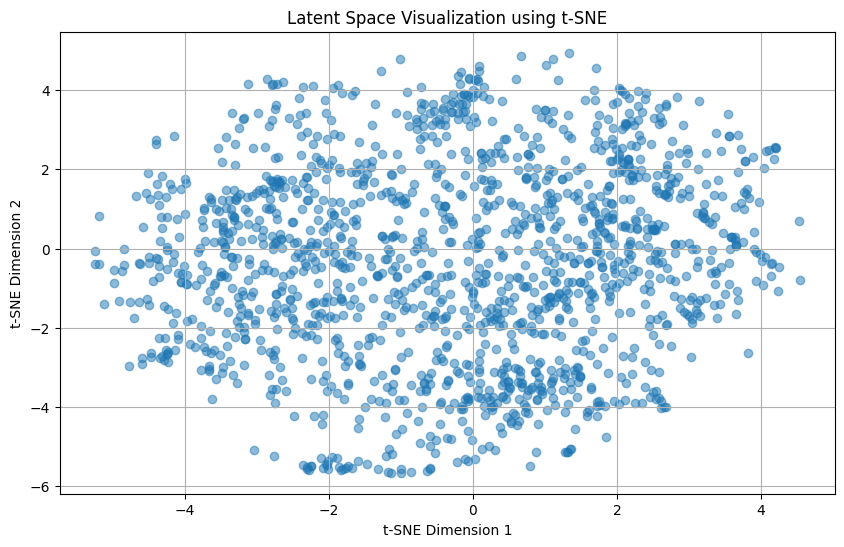

In [7]:
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def visualize_latent_space(vae, data_loader, device):
    mu_list = []
    for data in data_loader:
        data = data.to(device)
        with torch.no_grad():
            mu, _ = vae.enc(data)
            mu_list.append(mu)

    mu_tensor = torch.cat(mu_list, dim=0)
    mu_tensor = mu_tensor.view(mu_tensor.size(0), -1)
    tsne = TSNE(n_components=2, random_state=42, n_iter=5000, perplexity=500)
    mu_tsne = tsne.fit_transform(mu_tensor.cpu().numpy())

    plt.figure(figsize=(10, 6))
    plt.scatter(mu_tsne[:, 0], mu_tsne[:, 1], alpha=0.5)
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.show()

    return mu_tensor, mu_tsne  # Return the t-SNE transformed latent space for further use if needed


def find_interpolated_vector(t_sne_output, latent_vectors, point, k=5, device='cuda:0'):
    # Ensure that the latent vectors are moved to CPU for NumPy operations
    if isinstance(latent_vectors, torch.Tensor):
        latent_vectors = latent_vectors.cpu().numpy()
    
    # Fit Nearest Neighbors on t-SNE output
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(t_sne_output)
    distances, indices = nbrs.kneighbors([point])
    
    # Retrieve corresponding latent vectors
    latent_points = latent_vectors[indices[0]]
    
    # Interpolate based on distances
    weights = 1 / distances[0]
    interpolated_vector = np.average(latent_points, axis=0, weights=weights)
    
    # Convert the interpolated vector back to tensor and send to the specified device
    interpolated_vector_tensor = torch.tensor(interpolated_vector, dtype=torch.float32).to(device)
    
    return interpolated_vector_tensor

# Example usage:
point = [-2, 4]  # Point in the latent space
mu_tensor, t_sne_output = visualize_latent_space(vae, airfoil_dataloader, device)
interpolated_vector = find_interpolated_vector(t_sne_output, mu_tensor, point)


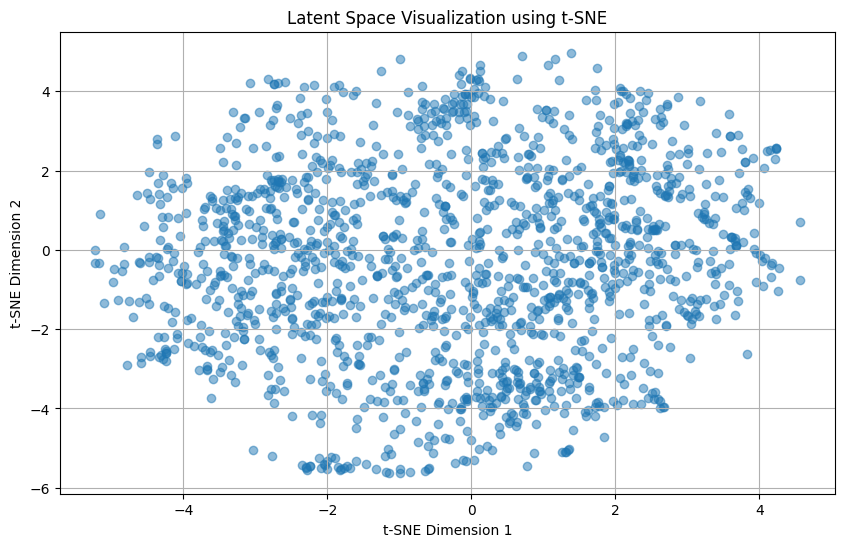

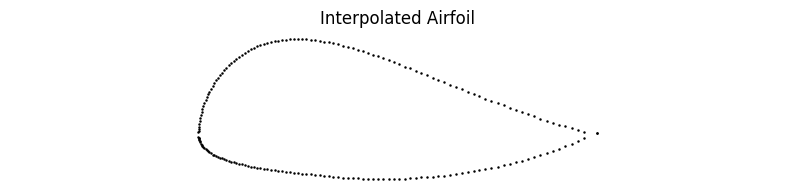

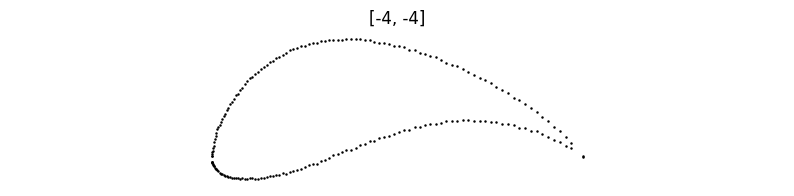

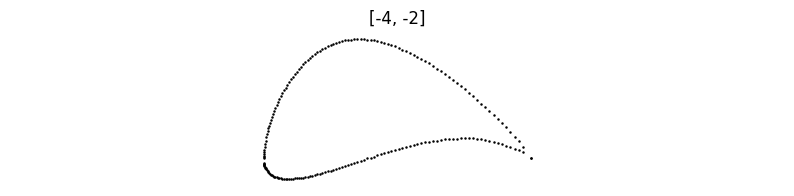

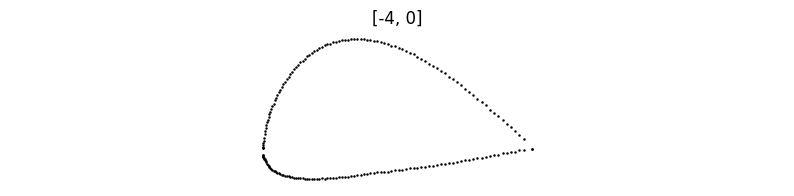

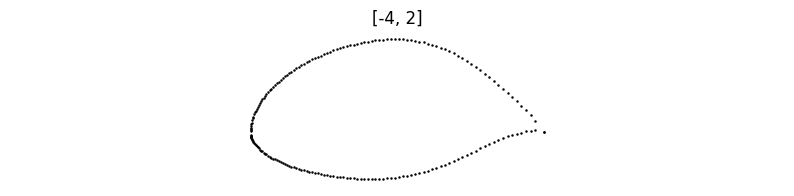

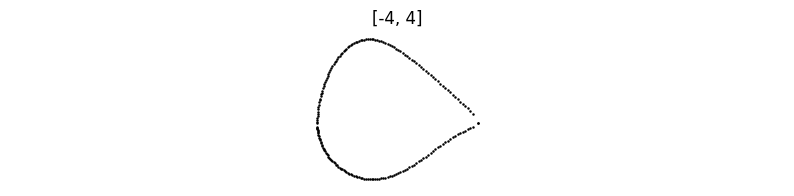

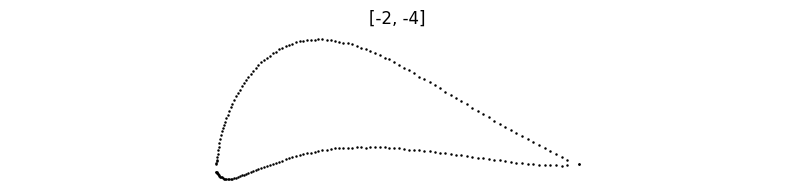

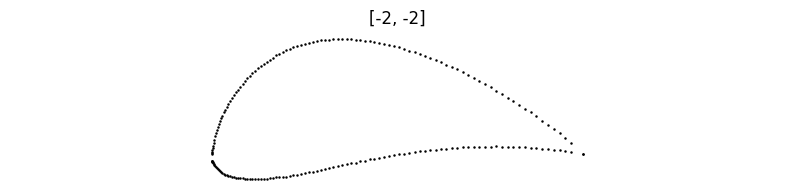

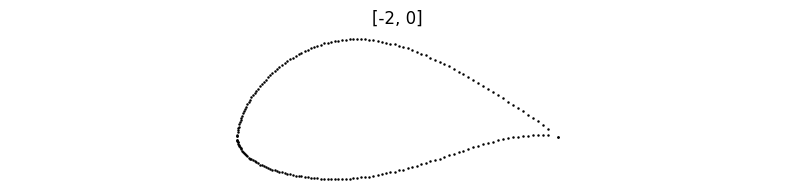

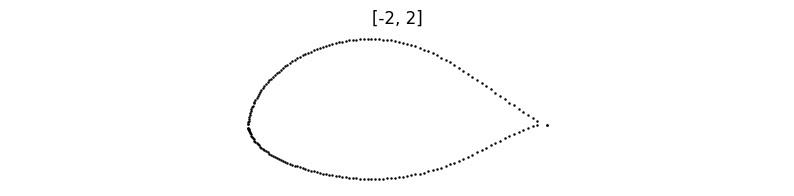

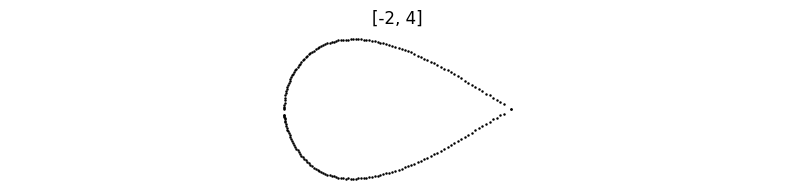

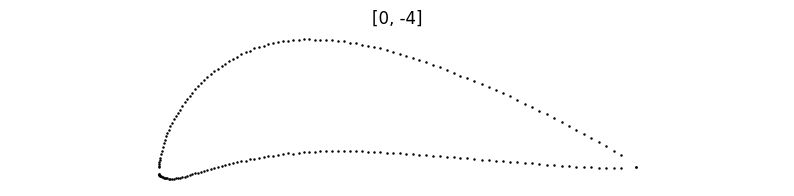

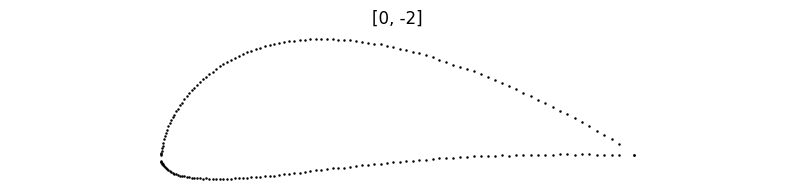

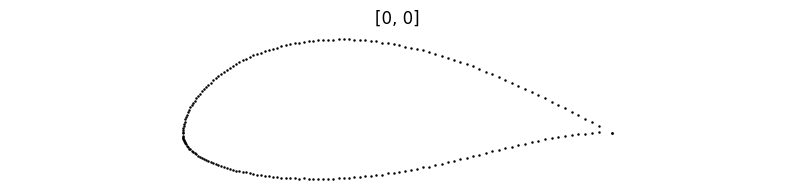

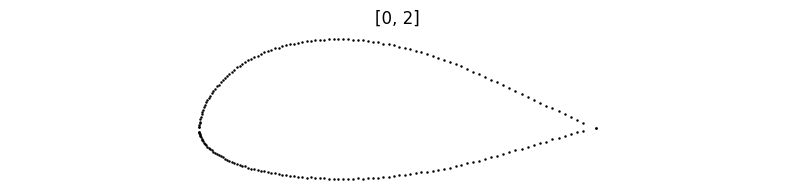

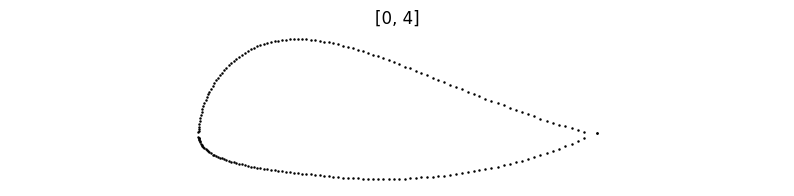

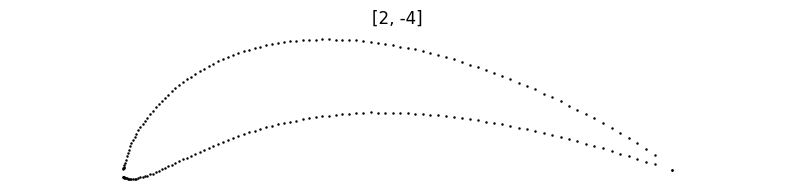

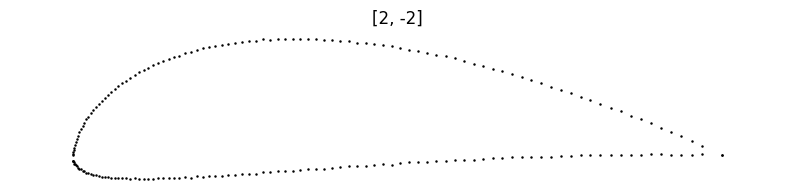

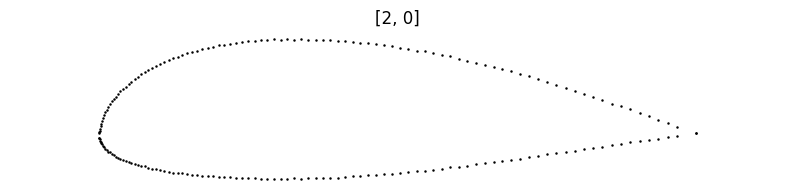

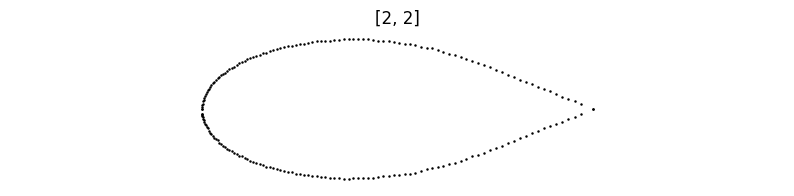

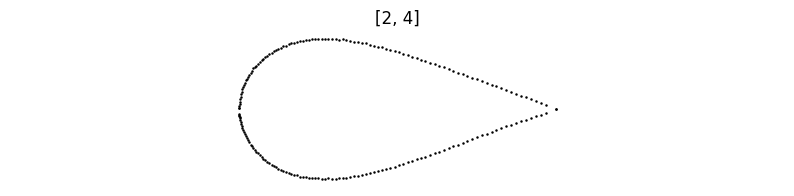

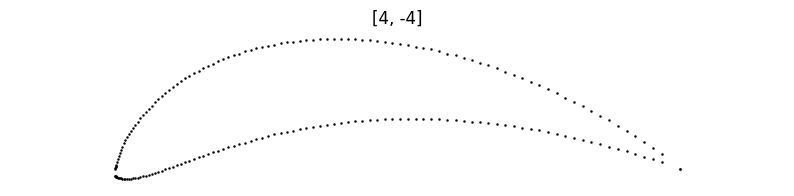

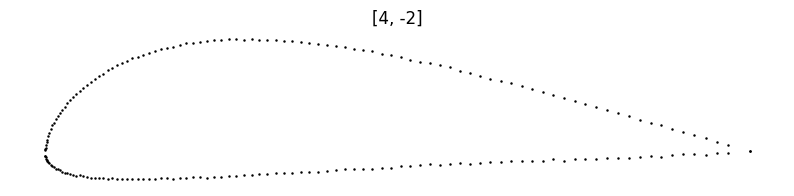

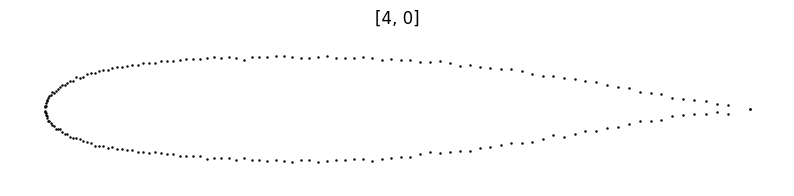

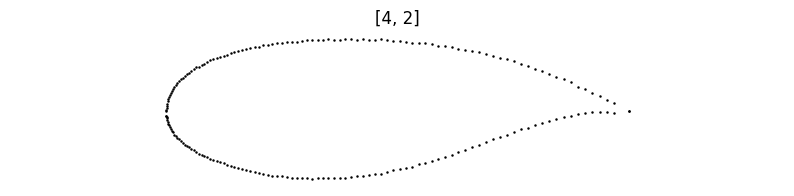

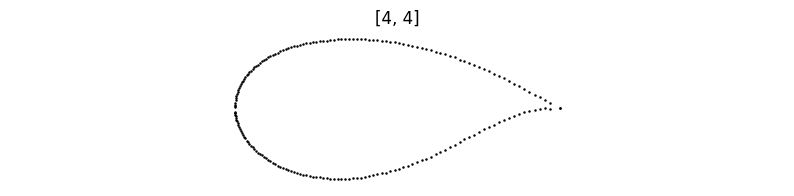

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_airfoil(airfoil_x, airfoil_y, title="Airfoil Plot"):
    plt.figure(figsize=(10, 2))
    plt.scatter(airfoil_x, airfoil_y, s=0.6, c='black')
    plt.axis('off')
    plt.axis('equal')
    plt.title(title)
    plt.show()


# Example usage
point = [0, 4]  # Chosen point on the t-SNE plot
mu_tensor, t_sne_output = visualize_latent_space(vae, airfoil_dataloader, device)
interpolated_vector = find_interpolated_vector(t_sne_output, mu_tensor, point, device=device)
decoder_output = vae.decode(interpolated_vector)
decoder_output = decoder_output.detach().cpu().numpy()
plot_airfoil(airfoil_x, decoder_output, title="Interpolated Airfoil")

points = []  # List of points to interpolate
for i in range(-4, 5, 2):
    for j in range(-4, 5, 2):
        points.append([i, j])
for point in points:
    interpolated_vector = find_interpolated_vector(t_sne_output, mu_tensor, point, device=device)
    decoder_output = vae.decode(interpolated_vector)
    decoder_output = decoder_output.detach().cpu().numpy()
    plot_airfoil(airfoil_x, decoder_output, title=point)

# Dataloader for latent space

Now that the VAE is trained, pass the data through the model to test reconstructed airfoils with xfoil

In [12]:
import os
# Ensure the model is in evaluation mode
airfoil_dataloader2 = DataLoader(dataset, batch_size=1, shuffle=True)
vae.eval()

# Disable gradient calculations
with torch.no_grad():
    # Create directory for outputs if it doesn't exist
    output_dir = 'vae_reconstructed'
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each sample and save reconstruction
    for batch_idx, local_batch in enumerate(airfoil_dataloader2):
        y_real = local_batch.to(device)
        recon_y, _, _ = vae(y_real)
        
        # Save reconstructed output
        save_path = os.path.join(output_dir, f'recon_{batch_idx + 1}.dat')
        with open(save_path, 'wb') as f:
            torch.save(recon_y.cpu(), f)

        # Optionally print progress
        print(f"Saved reconstruction {batch_idx + 1}/{len(airfoil_dataloader2)}")


Saved reconstruction 1/1543
Saved reconstruction 2/1543
Saved reconstruction 3/1543
Saved reconstruction 4/1543
Saved reconstruction 5/1543
Saved reconstruction 6/1543
Saved reconstruction 7/1543
Saved reconstruction 8/1543
Saved reconstruction 9/1543
Saved reconstruction 10/1543
Saved reconstruction 11/1543
Saved reconstruction 12/1543
Saved reconstruction 13/1543
Saved reconstruction 14/1543
Saved reconstruction 15/1543
Saved reconstruction 16/1543
Saved reconstruction 17/1543
Saved reconstruction 18/1543
Saved reconstruction 19/1543
Saved reconstruction 20/1543
Saved reconstruction 21/1543
Saved reconstruction 22/1543
Saved reconstruction 23/1543
Saved reconstruction 24/1543
Saved reconstruction 25/1543
Saved reconstruction 26/1543
Saved reconstruction 27/1543
Saved reconstruction 28/1543
Saved reconstruction 29/1543
Saved reconstruction 30/1543
Saved reconstruction 31/1543
Saved reconstruction 32/1543
Saved reconstruction 33/1543
Saved reconstruction 34/1543
Saved reconstruction 35

# 1-D Diffusion

In [ ]:
import torch.nn as nn
import torch
import math
from unet import Unet
from tqdm import tqdm

class AirfoilDiffusion(nn.Module):
    def __init__(self,latent_size,in_channels,out_channels,time_embedding_dim=256,timesteps=1000,base_dim=32,dim_mults= [1, 2, 4, 8], device="cuda"):
        super().__init__()
        
        ###
        #  Part a: Your code here
        ###
        self.latent_size=latent_size
        self.in_channels=in_channels
        self.timesteps=timesteps

    

        self.beta=self._cosine_variance_schedule(timesteps).to(device)
        self.alpha=(1.0-self.beta).to(device)
        self.alpha_bar=torch.cumprod(self.alpha,dim=-1).to(device)
        self.alpha_prev_bar=torch.cat([torch.tensor([1.0],device=self.alpha.device),self.alpha_bar[:-1]],dim=0)
        self.sqrt_alpha_bar=torch.sqrt(self.alpha_bar).to(device)
        self.sqrt_one_minus_alpha_bar=torch.sqrt(1.0-self.alpha_bar).to(device)


        self.model=Unet(timesteps,time_embedding_dim,in_channels,out_channels,base_dim,dim_mults)

        
    def _cosine_variance_schedule(self,timesteps,epsilon= 0.008):
        steps=torch.linspace(0,timesteps,steps=timesteps+1,dtype=torch.float32)
        f_t=torch.cos(((steps/timesteps+epsilon)/(1.0+epsilon))*math.pi*0.5)**2
        betas=torch.clip(1.0-f_t[1:]/f_t[:timesteps],0.0,0.999)

        return betas
        

    def forward(self, x, noise, cl_cd):
        # Combine Cl and Cd into a single tensor
        cond = cl_cd
        target_time = torch.randint(0, self.timesteps, (x.shape[0],), device=x.device)
        #print("target time type in forward: ", target_time.type())
        #print("target time shape in forward: ", target_time.shape)
        #print("noise shape in forward: ", noise.shape)
        #print("cond shape in forward: ", cond.shape)
        x_t = self._forward_diffusion(x, target_time, noise, cond)
        #print("x_t shape in forward: ", x_t.shape)
        pred = self.model(x_t, target_time, cond)
        return pred

    
    
    def _forward_diffusion(self, x_0, t, noise, cond):
        Cl = cond[:, 0].unsqueeze(1).unsqueeze(2)  # Shape becomes [batch_size, 1, 1] compatible with x_0
        Cd = cond[:, 1].unsqueeze(1).unsqueeze(2)  # Same as above

        alpha_scaled = self.sqrt_alpha_bar[t].unsqueeze(1).unsqueeze(2)  # Ensure shape is [batch_size, 1, 1]
        one_minus_alpha_scaled = self.sqrt_one_minus_alpha_bar[t].unsqueeze(1).unsqueeze(2)  # Same as above

        q = alpha_scaled * x_0 * (1 + 0.1 * Cl) + one_minus_alpha_scaled * noise * (1 + 0.1 * Cd)

        return q


    @torch.no_grad()
    def _reverse_diffusion(self, x_t, t, noise, cl_cd):
        alpha_t = self.alpha[t]
        beta_t = self.beta[t]
        sqrt_one_minus_alpha_t_cumprod = self.sqrt_one_minus_alpha_bar[t]

        # Pass cl_cd as part of the model's prediction process
        #print("cl_cd shape: ", cl_cd.shape)
        #print("t type in reverse diffusion: ", t.type())
        #print("t shape in reverse diffusion: ", t.shape)
        #print("x_t shape in reverse diffusion: ", x_t.shape)
        prediction = self.model(x_t, t, cl_cd)  
        #print("prediction shape in reverse diffusion: ", prediction.shape)

        a = (1 / torch.sqrt(alpha_t)).reshape(x_t.shape[0], 1, 1)
        beta_t_reshaped = beta_t.view(-1, 1, 1)
        #print("beta_t_reshaped shape in reverse diffusion: ", beta_t_reshaped.shape)
        sqrt_one_minus_alpha_t_cumprod_reshaped = sqrt_one_minus_alpha_t_cumprod.view(-1, 1, 1)
        #print("sqrt_one_minus_alpha_t_cumprod_reshaped shape in reverse diffusion: ", sqrt_one_minus_alpha_t_cumprod_reshaped.shape)

        b = (x_t - (beta_t_reshaped / sqrt_one_minus_alpha_t_cumprod_reshaped) * prediction)
        #print("b shape in reverse diffusion: ", b.shape)
        mu = a * b
       #print("mu shape in reverse diffusion: ", mu.shape)

        if t.min() > 0:
            sigma = torch.sqrt(beta_t_reshaped)
        else:
            sigma = torch.tensor(0.0).to(x_t.device)

        return mu + sigma * noise
    @torch.no_grad()
    def sampling(self, n_samples, cl_cd_values, device="cuda"):
        # Initialize noise
        sample = torch.randn(n_samples, self.in_channels, self.latent_size, device=device)
        #print("sample shape in sampling: ", sample.shape)
        all_samples = [sample]

        # Assume cl_cd_values is a tensor of shape [n_samples, num_conditions]
        cl_cd_values = cl_cd_values.to(device)

        # Reverse diffusion process
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.full((n_samples,), t, dtype=torch.int64, device=device)
            #print("t_tensor shape in sampling: ", t_tensor.shape)
            sample = self._reverse_diffusion(sample, t_tensor, torch.randn_like(sample, device=device), cl_cd_values)
            sample.clamp_(-1, 1)
            all_samples.append(sample)

        all_samples = torch.stack(all_samples, dim=0)
        return sample.clone(), all_samples.clone()
            


In [ ]:
lr = 0.01
epochs = 100
timesteps = 500

log_freq = 10


model = AirfoilDiffusion(32, 1, 1).to(device)

optimizer = Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=10)
loss_fn = nn.L1Loss()

for i in range(epochs):
    model.train()
    epoch_loss = 0
    for data, cl_cd in airfoil_dataloader:
        #print(cl_cd)
        data = data.to(device)
        mu, _ = vae.enc(data)
        mu = mu.to(device)
        #print("mu shape: ", mu.shape)
        cl_cd = cl_cd.to(device)
        #print("cl_cd shape: ", cl_cd.shape)
        noise = torch.randn_like(mu, device=device)
        #print("noise shape: ", noise.shape)
        pred = model(mu,noise,cl_cd)
        loss = loss_fn(pred,noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().cpu().item()
    epoch_loss /= len(airfoil_dataloader)
    scheduler.step(epoch_loss)
    print(f"epoch {i} loss {epoch_loss} lr {optimizer.param_groups[0]['lr']}")



epoch 0 loss 0.4652065201239152 lr 0.01
epoch 1 loss 0.2839453671272699 lr 0.01
epoch 2 loss 0.2702170097595685 lr 0.01
epoch 3 loss 0.2398707044202012 lr 0.01
epoch 4 loss 0.22917700762098486 lr 0.01
epoch 5 loss 0.22253980884304295 lr 0.01
epoch 6 loss 0.2131444877618319 lr 0.01
epoch 7 loss 0.21202115288802556 lr 0.01
epoch 8 loss 0.2042098267898931 lr 0.01
epoch 9 loss 0.19450444582994883 lr 0.01
epoch 10 loss 0.19182820695561248 lr 0.01
epoch 11 loss 0.20156616088631865 lr 0.01
epoch 12 loss 0.19877157486104347 lr 0.01
epoch 13 loss 0.19772692005355635 lr 0.01
epoch 14 loss 0.18245194223407027 lr 0.01
epoch 15 loss 0.1768310728978801 lr 0.01
epoch 16 loss 0.18774326397227004 lr 0.01
epoch 17 loss 0.17147825348686863 lr 0.01
epoch 18 loss 0.1846276492654503 lr 0.01
epoch 19 loss 0.17624230508680466 lr 0.01
epoch 20 loss 0.172078845079069 lr 0.01
epoch 21 loss 0.1693880372233205 lr 0.01
epoch 22 loss 0.16602375116441156 lr 0.01
epoch 23 loss 0.1695705173271043 lr 0.01
epoch 24 loss 

# Make some samples

In [ ]:
n_samples = 16
cl_cd = torch.tensor([[0.5, 0.5]]).repeat(n_samples, 1).to(device)
print("cl_cd shape: ", cl_cd.shape)
sample, all_samples = model.sampling(n_samples, cl_cd, device=device)


cl_cd shape:  torch.Size([16, 2])


In [ ]:
# make a range of cl_cd values
num_values = n_samples*2
linear_tensor = torch.linspace(0, 1, num_values)
cl_cd_values = linear_tensor.reshape(16,2).to(device)
print("cl_cd_values shape: ", cl_cd_values.shape)
print("cl_cd_values: ", cl_cd_values)
sample, all_samples = model.sampling(n_samples, cl_cd_values, device=device)

cl_cd_values shape:  torch.Size([16, 2])
cl_cd_values:  tensor([[0.0000, 0.0323],
        [0.0645, 0.0968],
        [0.1290, 0.1613],
        [0.1935, 0.2258],
        [0.2581, 0.2903],
        [0.3226, 0.3548],
        [0.3871, 0.4194],
        [0.4516, 0.4839],
        [0.5161, 0.5484],
        [0.5806, 0.6129],
        [0.6452, 0.6774],
        [0.7097, 0.7419],
        [0.7742, 0.8065],
        [0.8387, 0.8710],
        [0.9032, 0.9355],
        [0.9677, 1.0000]], device='cuda:0')


In [ ]:
sample = sample.squeeze()
print("sample shape: ", sample.shape)

sample shape:  torch.Size([16, 32])


In [ ]:
generated_airfoils = vae.decode(sample).detach().cpu().numpy()
print("generated_airfoils shape: ", generated_airfoils.shape)

generated_airfoils shape:  (16, 200)


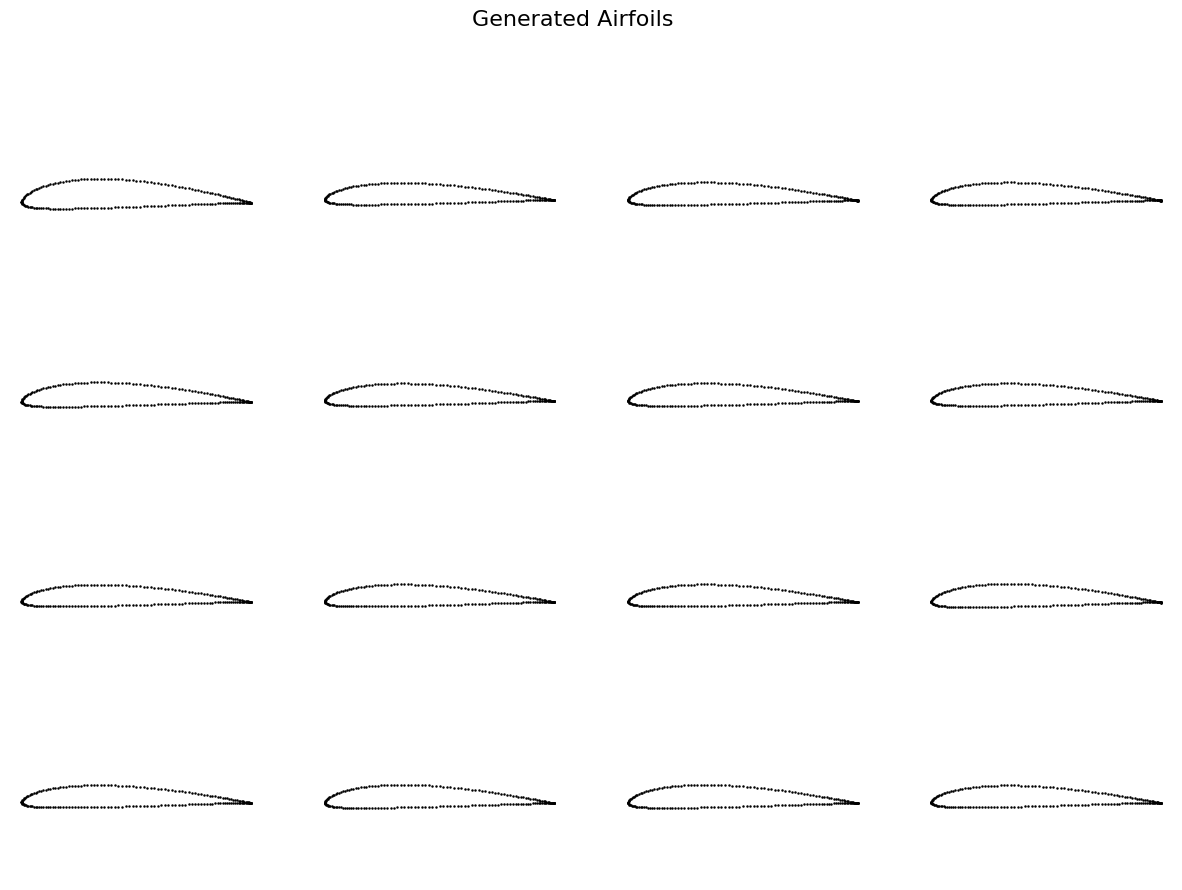

In [ ]:
plot_airfoils(airfoil_x, generated_airfoils, title="Generated Airfoils")